In [234]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [235]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [316]:
path = "allinputnet"
mtlibpath_prefix ="allinputnet_mtl"

Nx=128
Ny=128

Lx= 50
Ly= 50
T_end = 1
dt = 0.005

myubatch_size = 1024

input_to_defect_ratio_sqrt = 2
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 531.92it/s]


Unique Myus count	 8192
Max value of myu:	 134.21326259857332
Min value of myu:	 14.168173155256882
Unique values: [14.168173155256882, 15.70858859980428, 18.509650978118298, 20.12330440403532, 20.36777056775944, 21.183132520344625, 21.572368969844298, 22.165129164574008, 22.597099328278098, 22.88860261830339, 22.936366340362596, 23.927216223113405, 24.087110150035322, 24.359132773360074, 24.496019480907297, 24.571715858785616, 24.686141867318682, 24.91433108409929, 25.004321672906478, 25.005978278747847, 25.336528450448526, 25.350324484780106, 25.657977386331194, 25.803853482013057, 25.851154284086064, 25.916730895289454, 25.9882221712974, 26.057617711801335, 26.3008836410747, 26.31851926405417, 26.35140220857048, 26.356500618341943, 26.36519950167515, 26.449833878316394, 26.473403868973847, 26.51811157812416, 26.66972979965993, 26.70350314723095, 26.75079462545833, 27.003878350233446, 27.032538480172292, 27.06674873857407, 27.247863555016796, 27.306224244446547, 27.313169288438882, 2

In [317]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 68.72it/s]


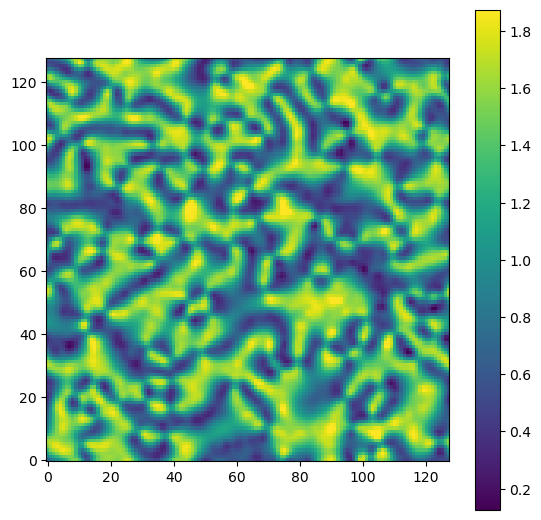

In [318]:
output_plot(A_norm, mem_rate)

In [319]:
def score(A):
    return np.var([np.var(a) for a in A.squeeze()])

def exponent(A, a):
    assert a > 0 
    A = A.squeeze()
    shp = A.shape[0]
    
    multm = (1/(1 - np.exp(np.arange(1,shp+1) * -(1/a))))
    return  (multm * A.T).T


score(exponent(A_original, 170))

144610.79939280375

In [320]:
import math
def golden_section_search(func, a, b, tol=1e-6):
    """
    Golden section search algorithm to minimize a function within a given interval.

    Parameters:
        func (function): The function to be minimized.
        a (float): The lower bound of the interval.
        b (float): The upper bound of the interval.
        tol (float): The tolerance level for convergence (default: 1e-6).

    Returns:
        float: The value of x that minimizes the function.

    """
    # Golden ratio
    golden_ratio = (1 + math.sqrt(5)) / 2

    # Initial interval points
    x1 = b - (b - a) / golden_ratio
    x2 = a + (b - a) / golden_ratio

    # Initial function values
    f1 = func(x1)
    f2 = func(x2)

    # Main loop
    while abs(b - a) > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            x1 = b - (b - a) / golden_ratio
            f2 = f1
            f1 = func(x1)
        else:
            a = x1
            x1 = x2
            x2 = a + (b - a) / golden_ratio
            f1 = f2
            f2 = func(x2)

    # Return the midpoint of the final interval
    return (a + b) / 2

In [321]:
a = golden_section_search(lambda x: score(exponent(A_original, x)), a = 0, b = 10000, tol = 1)

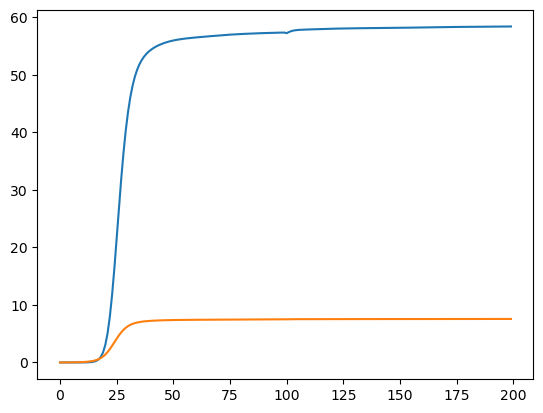

In [322]:
plt.plot([np.var(a) for a in A_original.squeeze()])
plt.plot([np.mean(np.abs(a)) for a in A_original.squeeze()])
#plt.yscale('log')

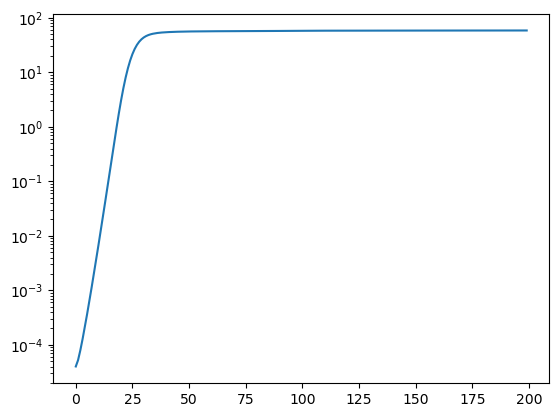

In [326]:

plt.plot([np.var(a) for a in A_original.squeeze()])
plt.yscale('log')

In [325]:
[np.var(a) for a in A_original.squeeze()]

[4.0200208e-05,
 5.2511e-05,
 7.9472e-05,
 0.000128152,
 0.00021440905,
 0.0003677304,
 0.0006423069,
 0.0011380307,
 0.0020399736,
 0.0036928034,
 0.006741544,
 0.0123986,
 0.022951145,
 0.042724412,
 0.07989992,
 0.14989382,
 0.28140885,
 0.52643627,
 0.974056,
 1.762341,
 3.0743513,
 5.1061068,
 8.010545,
 11.830447,
 16.443794,
 21.56676,
 26.828068,
 31.86822,
 36.414192,
 40.31182,
 43.52079,
 46.08506,
 48.095154,
 49.6561,
 50.866787,
 51.810402,
 52.552704,
 53.14405,
 53.622257,
 54.0154,
 54.34417,
 54.62368,
 54.864746,
 55.074966,
 55.259712,
 55.422916,
 55.567554,
 55.695927,
 55.809883,
 55.91102,
 56.000774,
 56.080505,
 56.151493,
 56.214954,
 56.27201,
 56.323708,
 56.37098,
 56.414654,
 56.45546,
 56.49402,
 56.530853,
 56.566402,
 56.60103,
 56.63501,
 56.66856,
 56.70185,
 56.735023,
 56.76819,
 56.80137,
 56.834465,
 56.867226,
 56.899284,
 56.93027,
 56.95989,
 56.987953,
 57.014385,
 57.039223,
 57.062576,
 57.084618,
 57.105553,
 57.125576,
 57.144875,
 57.163

In [331]:
import math

def sigmoid(a):
    """
    Sigmoid function.

    Parameters:
        a (float): Input value.

    Returns:
        float: Sigmoid value.

    """
    return 1 / (1 + math.exp(-a))


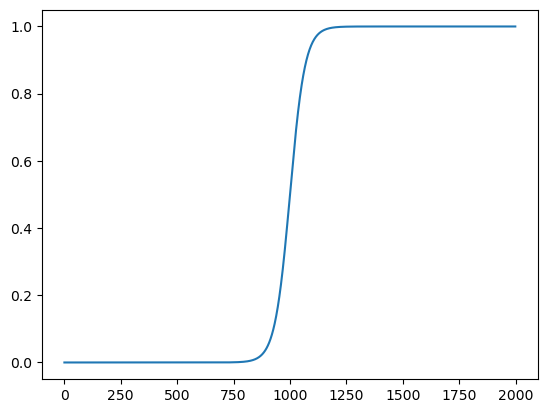

In [332]:

plt.plot(np.array(list(map(sigmoid, np.arange(-10,10,0.01)*3))))